In [1]:
import re
import pandas as pd
import numpy as np
from string import ascii_uppercase
import itertools
import random
import matplotlib.pyplot as plt

### Load data and preprocess

In [2]:
source_dir = "../data/fig14b/"
source_file  = "TPC-DS-50runs-A-H.csv"

class InFile(object):
    """Process strings as the file is being loaded"""
    
    def __init__(self, infile):
        self.infile = open(infile)

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self

    def read(self, *args, **kwargs):
        return self.__next__()

    def next(self):
        try:
            line = self.infile.readline()
            
            line = re.sub(r'  +', r',', line) 
            line = re.sub(r' ', r',', line) 

            return line
        except:
            self.infile.close()
            raise StopIteration

x = pd.read_csv(InFile(source_dir + source_file), header=0)
x.columns = ["query_raw", "Network", "Runtime"]

x["Query"] = x["query_raw"].apply(lambda xx: xx.replace("-v1.4", "")) 
    
tpc = x[["Query", "Network", "Runtime"]]

display(tpc.sample(10))
tpc["Query"].value_counts()

,Query,Network,Runtime
641,q3,E,10.748219
1427,q68,E,23.933288
728,q3,G,18.279889
1876,q82,F,19.533224
1810,q82,E,17.949196
1464,q68,F,33.518153
1703,q82,C,20.804225
1185,q53,H,20.972352
1234,q68,A,87.234908
1685,q82,B,24.906276


q53    400
q68    400
q82    400
q3     400
q46    400
Name: Query, dtype: int64

### Confidence Intervals: Estimation and Plotting 

In [3]:
def ci_p(s, p):
    """ 
    For values in the given array s and p in [0, 1], this fuction returns 
    empirical p-quantile value and its nonparametric 95% confidence interval.
    
    Refer to book by Boudec: https://infoscience.epfl.ch/record/146812/files/perfPublisherVersion_1.pdf,
    (Page 36 describes how nonparametric confidence intervals can be obtained for p-quantiles)
    """
    n = len(s)
    q = np.quantile(s, p)
    eta = 1.96 # for gamma = 0.95
    
    lo_rank = max(int(np.floor(n * p - eta * np.sqrt(n * p * (1-p)))), 0)
    hi_rank = min(int(np.ceil(n * p + eta * np.sqrt(n * p * (1-p))) + 1), n-1)
    
    s_sorted = sorted(s.tolist())
    q_ci_lo = s_sorted[lo_rank]
    q_ci_hi = s_sorted[hi_rank]
    
    return q, q_ci_lo, q_ci_hi

# Test for median
print ci_p(tpc["Runtime"][:20], 0.5)

(63.137505903000005, 57.465231588, 76.76931700899999)


### More detailed analysis of 3-, 5-, and 10-run sets

#### 0.9 quantiles for TPC-DS

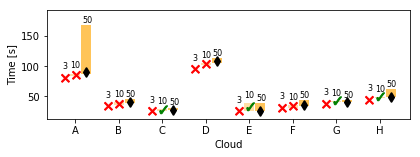

In [4]:
# Plotting is similar to the code above

p = 0.9

q = "q68"
q_df = tpc[tpc["Query"] == "q68"]

    
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2))

n_list = []
for n_idx, (n, grp) in enumerate(q_df.groupby("Network")):
    df = pd.DataFrame()
    n_list.append(n)

    for r in [10, len(grp)]:
        med, ci_lo, ci_hi = ci_p(np.array(grp["Runtime"].tolist()[:r]), p)
        df = pd.concat([df, pd.DataFrame([{"Reps": r, "Med": med, "CI Lo": ci_lo, "CI Hi": ci_hi}])])


    # Vis results for 10
    ax.errorbar(n_idx * 4 + 1, df["Med"].tolist()[0], yerr=[np.array([df["Med"].tolist()[0]-df["CI Lo"].tolist()[0]]), 
                                                 np.array([df["CI Hi"].tolist()[0]-df["Med"].tolist()[0]])], \
                     c="orange", fmt='', lw = 10, alpha=0.35)

    if df["CI Lo"].tolist()[-1] <= df["Med"].tolist()[0] <= df["CI Hi"].tolist()[-1]:
        ax.plot(n_idx * 4 + 1-0.075, df["Med"].tolist()[0], "green", alpha=1.0, marker=ur'$\u2713$', markersize=10)
    else:
        ax.plot(n_idx * 4 + 1-0.075, df["Med"].tolist()[0], "red", alpha=1.0, marker="$\\times$", markersize=10)

    plt.annotate("10", xy=(n_idx * 4 + 1 - 0.45, df["CI Hi"].tolist()[0] + 10), fontsize=8)
        
    # Vis results for 5
    ax.errorbar(n_idx * 4 + 2.0, df["Med"].tolist()[-1], yerr=[np.array([df["Med"].tolist()[-1]-df["CI Lo"].tolist()[-1]]), 
                                                 np.array([df["CI Hi"].tolist()[-1]-df["Med"].tolist()[-1]])], \
                     c="orange", fmt='', lw = 10, alpha=0.65, zorder=1)
    ax.scatter(n_idx * 4 + 2.0, df["Med"].tolist()[-1], c='black', marker="d", lw =2.0, zorder=2)

    plt.annotate("50", xy=(n_idx * 4 + 2.0 - 0.4, df["CI Hi"].tolist()[-1] + 5), fontsize=8)

    # Vis results for 3
    if df["CI Lo"].tolist()[-1] <= np.median(grp["Runtime"].tolist()[:3]) <= df["CI Hi"].tolist()[-1]:
        ax.plot(n_idx * 4 -0.075, np.median(grp["Runtime"].tolist()[:3]), "green", alpha=1.0, marker=ur'$\u2713$', markersize=10)
    else:
        ax.plot(n_idx * 4 -0.075, np.median(grp["Runtime"].tolist()[:3]), "red", alpha=1.0, marker="$\\times$", markersize=10)

    plt.annotate("3", xy=(n_idx * 4 - 0.2, np.median(grp["Runtime"].tolist()[:3]) + 15), fontsize=8)

# Additional styling
ax.set_xticks(np.array(range(n_idx + 1)) * 4 + 1.0)
ax.set_xticklabels(n_list)
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 1.1])
ax.set_ylabel("Time [s]")
ax.set_xlabel("Cloud");